In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from tqdm.auto import tqdm  
import spacy 
nlp = spacy.load('en_core_web_lg') # large model
import nltk
from nltk.corpus import words
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
import warnings
warnings.filterwarnings("ignore")

from src.data.process_pdfs import convert_pdf_to_txt, clean_text, mask_companies_spacy, transform_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jbaumert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jbaumert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jbaumert/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /home/jbaumert/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 1. Extract text from pdfs

In [4]:
df = pd.read_excel('data/interim/reports_labeled_clean.xlsx')
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf
8155,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf


In [7]:
tqdm.pandas() # Display progressbar
df['CSR_Text'] = df['CSR_Filename'].progress_apply(convert_pdf_to_txt)

In [44]:
# Drop rows with errors
df = df[df['CSR_Text'] != 'Error']
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...
8155,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...


## 2. Clean text 

In [ ]:
tqdm.pandas() # Display progressbar
df['CSR_Text_clean'] = df['CSR_Text'].progress_apply(clean_text)

## 3. Mask company names

In [7]:
# Step 1: Use spaCy

tqdm.pandas() # Display progressbar
df['CSR_Text_clean'] = df['CSR_Text_clean'].progress_apply(mask_companies_spacy)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
# Step 2: Custom (mask each word in company name if not in nltk english words)

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Split company name into words
    company_words = row['Company_Name'].split()
    for word in company_words:
        # Exclude "normal" english words
        if (word not in words.words()) and (word.lower() not in words.words()):
            # Add spaces before and after word to prevent replacing parts of words
            word = ' ' + word + ' '   
            df.loc[index, 'CSR_Text_clean'] = df.loc[index, 'CSR_Text_clean'].replace(word,' ORG ').replace(word.lower(),' ORG ').replace(word.upper(),' ORG ')

  0%|          | 0/8141 [00:00<?, ?it/s]

## 4. Tokenize text 

In [ ]:
tqdm.pandas() # Display progressbar
df['CSR_Text_tokenized'] = df['CSR_Text_clean'].progress_apply(transform_text)

  0%|          | 0/8141 [00:00<?, ?it/s]

## 5. Cleanup

In [59]:
# Drop rows for which text could not be extracted
df = df[df['CSR_Text_tokenized'] != '']
# Reset index
df.reset_index(drop=True, inplace=True)
# Reset ID
df['ID'] = df.index
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [60]:
df.to_pickle('data/processed/reports_tokenized.p')

## 6. Explore final data

In [4]:
df = pd.read_pickle('data/processed/reports_tokenized.p')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8103 entries, 0 to 8102
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         8103 non-null   int64  
 1   Identifier                 8103 non-null   object 
 2   Company_Name               8103 non-null   object 
 3   ISIN                       8103 non-null   object 
 4   Ticker                     7993 non-null   object 
 5   Country_of_Exchange        8103 non-null   object 
 6   Financial_Period_Absolute  8103 non-null   int64  
 7   Financial_Period_Relative  8103 non-null   object 
 8   CSR_URL                    8103 non-null   object 
 9   SDG_1                      8103 non-null   bool   
 10  SDG_2                      8103 non-null   bool   
 11  SDG_3                      8103 non-null   bool   
 12  SDG_4                      8103 non-null   bool   
 13  SDG_5                      8103 non-null   bool 

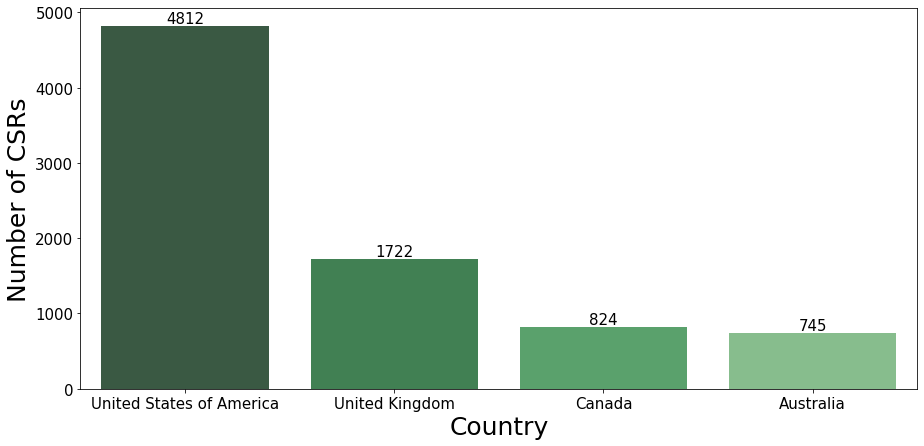

In [6]:
# Number of CSRs per country
xs = []
ys = []
for country in df['Country_of_Exchange'].unique():
    xs.append(country)
    ys.append(sum(df['Country_of_Exchange'] == country))

plt.figure(figsize=(15,7))
pal = sns.color_palette("Greens_d", len(ys))
ax = sns.barplot(x=xs, y=ys, order = df['Country_of_Exchange'].value_counts().index, palette=np.array(pal[::-1]))
ax.bar_label(ax.containers[0], fontsize=15)
plt.xlabel("Country", fontsize=25)
plt.ylabel("Number of CSRs", fontsize=25)
plt.tick_params(labelsize=15)
plt.show()

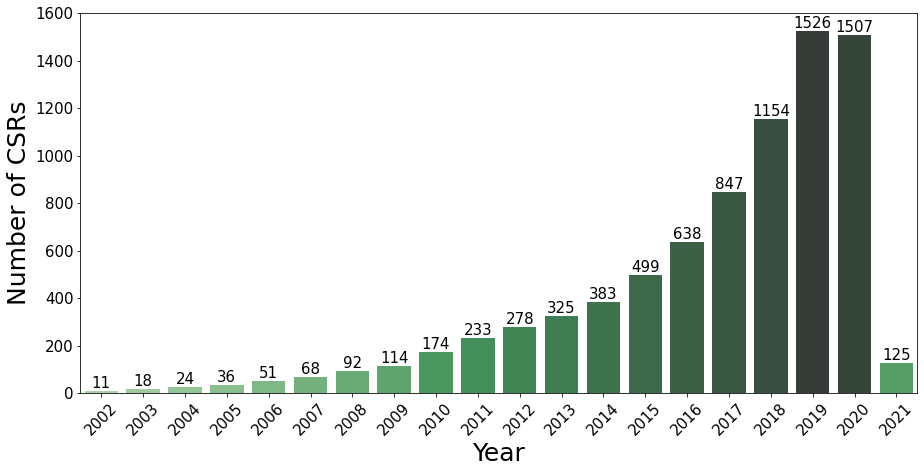

In [7]:
# Number of CSRs per year    
xs = []
ys = []
for year in np.sort(df['Financial_Period_Absolute'].unique()):
    xs.append(year)
    ys.append(sum(df['Financial_Period_Absolute'].astype(str) == str(year)))

plt.figure(figsize=(15,7))
pal = sns.color_palette("Greens_d", len(ys))
rank = np.array(ys).argsort().argsort()
ax = sns.barplot(x=xs, y=ys, palette=np.array(pal)[rank])
ax.bar_label(ax.containers[0], fontsize=15)
plt.xticks(rotation=45)
plt.xlabel("Year", fontsize=25)
plt.ylabel("Number of CSRs", fontsize=25)
plt.tick_params(labelsize=15)
plt.show()

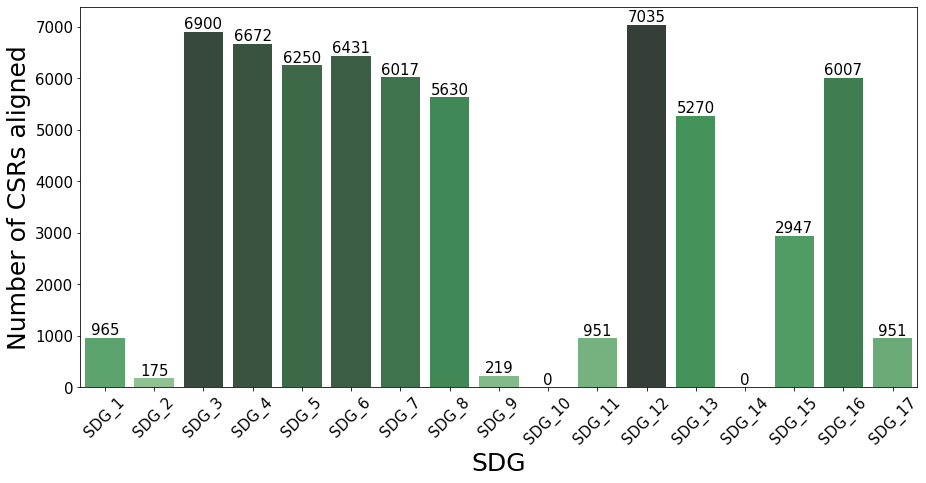

In [8]:
# Number of TRUE per SDG
xs = []
ys = []
for column in df.columns[9:26]:
    xs.append(column)
    ys.append(sum(df[column] == True))

plt.figure(figsize=(15,7))
pal = sns.color_palette("Greens_d", len(ys))
rank = np.array(ys).argsort().argsort()
ax = sns.barplot(x=xs, y=ys, palette=np.array(pal)[rank])
ax.bar_label(ax.containers[0], fontsize=15)
plt.xticks(rotation=45)
plt.xlabel("SDG", fontsize=25)
plt.ylabel("Number of CSRs aligned", fontsize=25)
plt.tick_params(labelsize=15)
plt.show()  

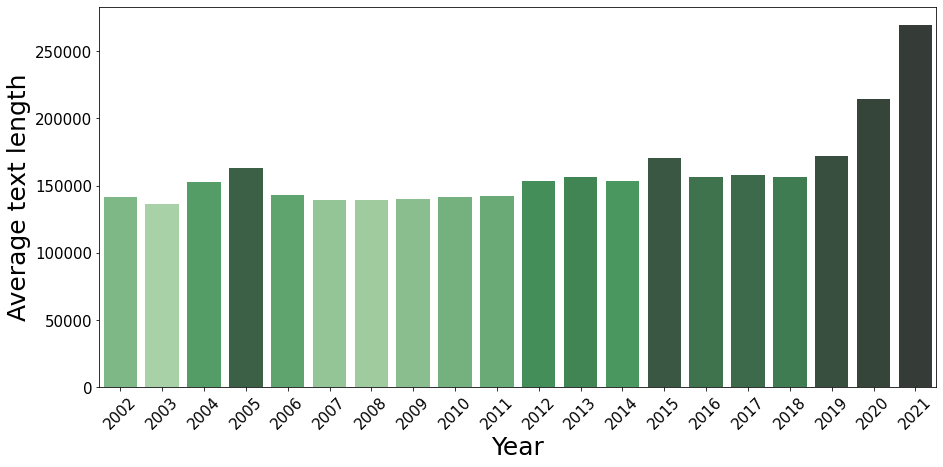

In [9]:
# Average text length per year    
xs = []
ys = []
for year in np.sort(df['Financial_Period_Absolute'].unique()):
    xs.append(year)
    ys.append(df[df['Financial_Period_Absolute'].astype(str) == str(year)]['CSR_Text_clean'].apply(len).mean())

plt.figure(figsize=(15,7))
pal = sns.color_palette("Greens_d", len(ys))
rank = np.array(ys).argsort().argsort()
ax = sns.barplot(x=xs, y=ys, palette=np.array(pal)[rank])
plt.xticks(rotation=45)
plt.xlabel("Year", fontsize=25)
plt.ylabel("Average text length", fontsize=25)
plt.tick_params(labelsize=15)
plt.show()